# Project Overview
In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, there was a significant amount of typically confidential information entered into public record, including tens of thousands of emails and detailed financial data for top executives.
In this project I will build a person of interest identifier based on financial and email data made public as a result of the Enron scandal. I use email and financial data for 146 executives at Enron to identify persons of interest in the fraud case. A person of interest (POI) is someone who was indicted for fraud, settled with the government, or testified in exchange for immunity. This report documents the machine learning techniques used in building a POI identifier.

In [253]:
import sys
import pickle
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as pl
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline



from sklearn import metrics
sys.path.append("../tools/")

from sklearn.cross_validation import StratifiedShuffleSplit
from feature_format import featureFormat, targetFeatureSplit
from sklearn.cross_validation import train_test_split
from tester import dump_classifier_and_data
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV

#files containing written code

from removeOutliers import removeOutliers
from featuresAdd import featuresAdd
from datasetOverview import datasetOverview
from ParameterDictionary import Params_dict
from GridSearchBestEstimation import EstimateBest

In [254]:
data_dict = pickle.load(open("final_project_dataset.pkl", "r") )

In [255]:
print "There are ", len(data_dict.keys()), " executives in Enron Dataset."

There are  146  executives in Enron Dataset.


In [256]:
print data_dict.keys()

['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R', 'HANNON KEVIN P', 'MORDAUNT KRISTINA M', 'MEYER ROCKFORD G', 'MCMAHON JEFFREY', 'HORTON STANLEY C', 'PIPER GREGORY F', 'HUMPHREY GENE E', 'UMANOFF ADAM S', 'BLACHMAN JEREMY M', 'SUNDE MARTIN', 'GIBBS DANA R', 'LOWRY CHARLES P', 'COLWELL WESLEY', 'MULLER MARK S', 'JACKSON CHARLENE R', 'WESTFAHL RICHARD K', 'WALTERS GARETH W', 'WALLS JR ROBERT H', 'KITCHEN LOUISE', 'CHAN RONNIE', 'BELFER ROBERT', 'SHANKMAN JEFFREY A', 'WODRASKA JOHN', 'BERGSIEKER RICHARD P', 'URQUHART JOHN A', 'BIBI PHILIPPE A', 'RIEKER PAULA H', 'WHALEY DAVID A', 'BECK SALLY W', 'HAUG DAVID L', 'ECHOLS JOHN B', 'MENDELSOHN JOHN', 'HICKERSON GARY J', 'CLINE KENNETH W', 'LEWIS RICHARD', 'HAYES ROBERT E', 'MCCARTY DANNY J', 'KOPPER MICHAEL J', 'LEFF DANIEL P', 'LAVORATO JOHN J', 'BERBERIAN DAVID', 'DETMERING TIMOTHY J', 'WAKEHAM JOHN', 'POWERS WILLIAM', 'GOLD JOSEPH', 'BANNANTINE JAMES M', 'DUNCAN JOHN H', 'SHAPIRO RICHARD S', 'SHERRIFF JOHN R', 'SHELBY 

# Data Overview

In [257]:
def datasetOverview(data_dict):
    
    '''
    This function outputs the number of data points and the
    information about pois in the enron dataset
    '''
    persons = 0 
    poi = 0
    notpoi = 0
    Nodataavailable=0
    for key,value in data_dict.iteritems():
        persons += 1
        for key1,value1 in value.iteritems(): 
        
            if key1 =='poi':
                if value1 == True:
                    poi += 1
                elif value1 == False:
                    notpoi += 1
                
                    
    print('Total Number of people under consideration :'+str(persons))
    print('Total Number of persons of interest under consideration :'+str(poi))
    print('Total Number of people who are not poi :'+str(notpoi))
            


In [258]:
 #Some info about dataset
datasetOverview(data_dict)
    

Total Number of people under consideration :146
Total Number of persons of interest under consideration :18
Total Number of people who are not poi :128


# Outlier Investigation
First of all I would like to have a look at my data and check it for outliers.

I plot salaries and bonuses on Enron employees and see an outlier in the data.

In [259]:
def removeOutliers(data_dict):
    '''
    Function to remove spreadsheet outlier
    
    '''
    
    import matplotlib.pyplot as pl  #Import matplotlib to plot scatterplot
    #plot salary vs bonus
    for name in data_dict:

        a=(data_dict[name]['salary'])

        b=(data_dict[name]['bonus'])

        pl.scatter(a,b)
        pl.xlabel("salary")
        pl.ylabel("bonus")  
       

    print 'Plot with outlier'

    pl.show()
   
    print 'The \'Total\' outlier :'
    
    # the outlier above is a spreadsheet error!

    print data_dict["TOTAL"] 
    data_dict.pop('TOTAL')
    print '\nOutlier Removed'
    print '\nNew Plot:'
   
    # plot again after removal of outlier
    
    for name in data_dict:
        a=(data_dict[name]['salary'])
        b=(data_dict[name]['bonus'])
        pl.scatter(a,b)
    pl.show()
    pl.xlabel("salary")
    pl.ylabel("bonus")
   
    return data_dict
   



Plot with outlier


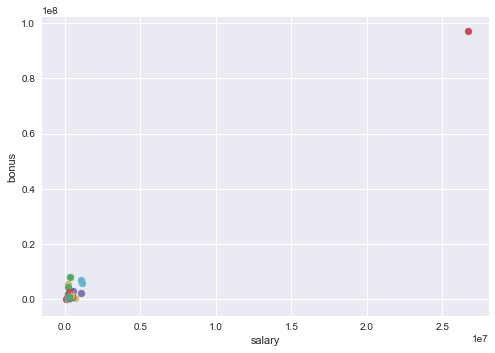

The 'Total' outlier :
{'salary': 26704229, 'to_messages': 'NaN', 'deferral_payments': 32083396, 'total_payments': 309886585, 'exercised_stock_options': 311764000, 'bonus': 97343619, 'restricted_stock': 130322299, 'shared_receipt_with_poi': 'NaN', 'restricted_stock_deferred': -7576788, 'total_stock_value': 434509511, 'expenses': 5235198, 'loan_advances': 83925000, 'from_messages': 'NaN', 'other': 42667589, 'from_this_person_to_poi': 'NaN', 'poi': False, 'director_fees': 1398517, 'deferred_income': -27992891, 'long_term_incentive': 48521928, 'email_address': 'NaN', 'from_poi_to_this_person': 'NaN'}

Outlier Removed

New Plot:


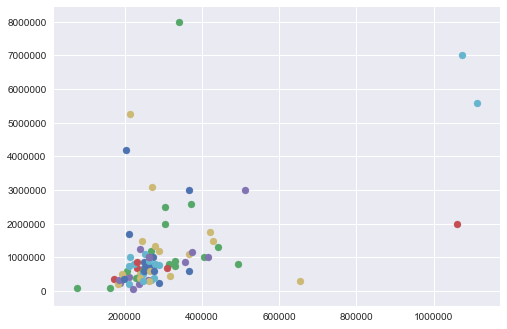

In [260]:
data_dict = removeOutliers(data_dict)


# New Feature
Persons of interest may have strong email connections. POIs might send emails to other POIs at a higher rate than the rest of the population. For this reason, let's create two new features: one that represents the fraction of emails that a person sent to POIs, and another feature that represents the fraction of emails that a person received from POIs.

In [261]:
def computeFraction(poi_messages, all_messages):
    """ given a number messages to/from POI (numerator) 
        and number of all messages to/from a person (denominator),
        return the fraction of messages to/from that person
        that are from/to a POI
   """
    fraction = 0.
    
    if poi_messages=='NaN' or all_messages=='NaN':
        fraction = 0.
    else:  
        fraction=float(poi_messages)/float(all_messages)

    return fraction


for name in data_dict:

    data_point = data_dict[name]

    from_poi_to_this_person = data_point["from_poi_to_this_person"]
    to_messages = data_point["to_messages"]
    fraction_from_poi = computeFraction( from_poi_to_this_person, to_messages )
    data_point["fraction_from_poi"] = fraction_from_poi


    from_this_person_to_poi = data_point["from_this_person_to_poi"]
    from_messages = data_point["from_messages"]
    fraction_to_poi = computeFraction( from_this_person_to_poi, from_messages )
    data_point["fraction_to_poi"] = fraction_to_poi

In [262]:
fraction_to_poi=[data_dict[key]["fraction_to_poi"] for key in data_dict]
fraction_from_poi=[data_dict[key]["fraction_from_poi"] for key in data_dict]
poi=[data_dict[key]["poi"]==1 for key in data_dict]

Let's create a scatter plot with the fraction of emails the person received from POIs against the fraction of emails the person sent to POIs.

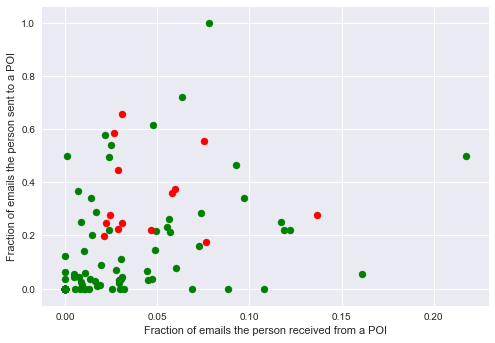

In [263]:
for i in range(len(poi)):
    if poi[i]==1:
        plt.scatter(fraction_from_poi[i],fraction_to_poi[i],c='red',s=50)
    else:
        plt.scatter(fraction_from_poi[i],fraction_to_poi[i],c='green',s=50)
plt.xlabel('Fraction of emails the person received from a POI') 
plt.ylabel('Fraction of emails the person sent to a POI') 
plt.show()

# Choosing and tuning the algorithm

In [264]:
def Params_dict(classifiers):
    ''''
    In this function a dictionary has been created about the parameters which 
    would be passed for each classsifier during the 'grid search'.
    '''
   
   # This list will be common to all classifiers and includes parameters passed for PCA 
   # and for slecting K best features from feature_list  

    featureParamList = dict( reduce__n_components=np.arange(1,4),
                               reduce__whiten =[True, 
                                                     False],
                               reduce__svd_solver =['auto', 
                                                         'full', 
                                                         'arpack', 
                                                         'randomized'],
                               selectK__k =[5,10,15])
    #parameters for SVC
    svcParam = dict(clf__C = [0.0001, 
                                0.001, 
                                0.01, 
                                0.1, 
                                1,10],
                          clf__gamma = [0.0005, 
                                        0.001, 
                                        0.005, 
                                        0.01, 
                                        0.1],
                          clf__kernel= ['rbf','linear'], 
                          clf__class_weight = ['balanced', 
                                               None])
    
    #parameters for DecisionTree
    decisionTreeParam = dict(clf__criterion = ['gini', 
                                                  'entropy'],
                                clf__max_features = ['sqrt', 
                                                     'log2', 
                                                     None],
                            clf__random_state=[56])
    #Parameters for RandomForest
    randomForestParam = dict(clf__n_estimators = np.arange(10, 30 ,10),
                                 clf__criterion = ['gini', 
                                                   'entropy'],
                                 clf__max_features = ['sqrt', 
                                                      'log2', 
                                                      None],
                                 clf__class_weight = ['balanced', 
                                                      None],
                                clf__random_state = [56])
    
    algoParametersList=[svcParam,decisionTreeParam,randomForestParam]
    
    
    ''' (In Main function)
    
     classifiers = [SVC(),
                   DecisionTreeClassifier(),
                   RandomForestClassifier(),
                   GaussianNB()]
    '''
    parameterDict={}
    #Avoiding GaussianNB in classifiers list in main function as it does not have its own parameters to tune hence -1
    for i,_ in  enumerate(classifiers[:-1]) :    
        
        algoParametersList[i].update(featureParamList)
        parameterDict.update({type(classifiers[i]):algoParametersList[i]})

    #for Gaussian Naive Bayes
    parameterDict.update({type(classifiers[3]):featureParamList})
    
    return parameterDict



def EstimateBest(classifier,params_list, cross_val, my_dataset, features_list,
                   features_train, labels_train, features_test, labels_test):
    
    
    parameterlist=params_list[type(classifier)]

    print('\n'+str(type(classifier)))
    
    print('\n wait....')

    # Create pipeline and pass the series of operations we expect to take place with a classifier at the end.
    
    estimators = [('scaler', preprocessing.MinMaxScaler()),
                  ('selectK', SelectKBest()),
                  ('reduce', PCA()), 
                  ('clf', classifier)]
    pipe = Pipeline(estimators) 
    
    #GridSearch algorithm to tune the dataset
    
    grid = GridSearchCV(pipe, 
                        param_grid = parameterlist, 
                        scoring = 'f1',
                        cv = cross_val)

    
    grid.fit(features_train, labels_train)
    
    #select the predictions of best_estimator classifier selected on basis of f1 scoring
    
    pred = grid.best_estimator_.predict(features_test)
    
    clf=grid.best_estimator_

    clf.fit(features_train, labels_train)

    pred = clf.predict(features_test)

    
    acc = clf.score(features_test, labels_test)
    prec = metrics.precision_score(labels_test, pred)
    rcl = metrics.recall_score(labels_test, pred)
    f1score = metrics.f1_score(labels_test, pred)

    print ('\n {} \n Accuracy = {} \n Precision = {} \n Recall = {} \n F1 Score = {} ').format(type(clf),
                                                                                         str(acc),
                                                                                         str(prec),str(rcl),str(f1score))


    #Show features selected for best_estimator and their weightage respectively
    
    feature_yesno = clf.named_steps['selectK'].get_support()
    
    #feature_yesno is a list of booleans correspoinding to the fearures list, where 
    # 1 represents feature selected and 0 represents feature rejected in best_estimator
    
    feature_weightage = clf.named_steps['selectK'].scores_
    print ('\n Feature:Weightage')
    
    for i in range(len(features_list)-1): 
        # since 'poi' is label and not feature we use 'length - 1'
        if feature_yesno[i]:
            print ('\n {}:{}').format(features_list[i+1],feature_weightage[i]) #since 'poi' is label and not feature we use i+1

    
    return clf


# Validation strategy and evluation metrics

To assess the performance of our algorithm we will look at two evaluation metrics:

Precision = true positives/(true positives + false positives)

Recall = true positives/(true positives + false negatives)

There’s usually a tradeoff between precision and recall. Sometimes the identifier doesn't have great precision, but it does have good recall. That means that, nearly every time a POI shows up in the test set, we are able to identify him or her. The cost of this is that we sometimes get some false positives, where non-POI get flagged.

Sometimes, instead, the identifier doesn't have a great recall, but it does have good precision. That means that whenever a POI gets flagged in the test set, we know with a lot of confidence that it's very likely to be a real POI and not a false alarm.
On the other hand, the price we pay for this is that we sometimes miss real POIs, since we are reclucant to pull the trigger on edge cases.

For this project we want that precision and recall are both at least 0.3.

Plot with outlier


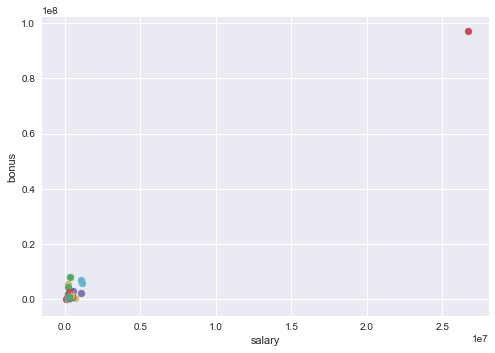

The 'Total' outlier :
{'salary': 26704229, 'to_messages': 'NaN', 'deferral_payments': 32083396, 'total_payments': 309886585, 'exercised_stock_options': 311764000, 'bonus': 97343619, 'restricted_stock': 130322299, 'shared_receipt_with_poi': 'NaN', 'restricted_stock_deferred': -7576788, 'total_stock_value': 434509511, 'expenses': 5235198, 'loan_advances': 83925000, 'from_messages': 'NaN', 'other': 42667589, 'from_this_person_to_poi': 'NaN', 'poi': False, 'director_fees': 1398517, 'deferred_income': -27992891, 'long_term_incentive': 48521928, 'email_address': 'NaN', 'from_poi_to_this_person': 'NaN'}

Outlier Removed

New Plot:


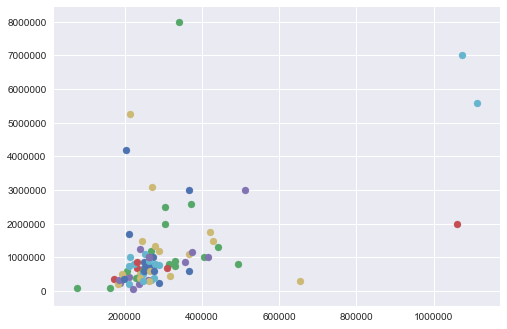

Total Number of people under consideration :145
Total Number of persons of interest under consideration :18
Total Number of people who are not poi :127

 <class 'sklearn.svm.classes.SVC'> 
 Accuracy = 0.886363636364 
 Precision =0.0 
 Recall = 0.0 
 F1 Score = 0.0

 <class 'sklearn.tree.tree.DecisionTreeClassifier'> 
 Accuracy = 0.840909090909 
 Precision =0.25 
 Recall = 0.2 
 F1 Score = 0.222222222222

 <class 'sklearn.ensemble.forest.RandomForestClassifier'> 
 Accuracy = 0.886363636364 
 Precision =0.0 
 Recall = 0.0 
 F1 Score = 0.0

 <class 'sklearn.naive_bayes.GaussianNB'> 
 Accuracy = 0.818181818182 
 Precision =0.2 
 Recall = 0.2 
 F1 Score = 0.2

 After Tuning

<class 'sklearn.naive_bayes.GaussianNB'>

 wait....

 <class 'sklearn.pipeline.Pipeline'> 
 Accuracy = 0.886363636364 
 Precision = 0.5 
 Recall = 0.4 
 F1 Score = 0.444444444444 

 Feature:Weightage

 salary:15.5109752518

 total_payments:6.99029648936

 exercised_stock_options:20.1830072583

 bonus:11.4236716964

 res

In [265]:

def main():
    
    
    features_list = ['poi', 'salary', 'to_messages', 'deferral_payments',
                     'total_payments', 'exercised_stock_options', 'bonus',
                     'restricted_stock', 'shared_receipt_with_poi',
                     'restricted_stock_deferred', 'total_stock_value',
                     'expenses', 'loan_advances', 'from_messages', 'other',
                     'from_this_person_to_poi', 'director_fees', 'deferred_income',
                     'long_term_incentive', 'from_poi_to_this_person','proportion_of_poi_mssgs'] 

    #Open datafile as dictionary
    with open("final_project_dataset.pkl", "r") as data_file:
        data_dict = pickle.load(data_file)

    #Remove Outliers
    data_dict = removeOutliers(data_dict)
    
    #Some info about dataset
    datasetOverview(data_dict)
    
    #Add some required features
    data_dict = featuresAdd(data_dict)
    
    
    data = featureFormat(data_dict, features_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)

    #Simple train test split
    features_train, features_test, labels_train, labels_test =     train_test_split(features, labels, test_size=0.3, random_state=56)


    classifiers = [SVC(),
                   DecisionTreeClassifier(random_state=60),
                   RandomForestClassifier(random_state=60),
                   GaussianNB()]

    #iterator to run all classifers on the data
    
    for clf in classifiers:
        clf.fit(features_train, labels_train)
        pred = clf.predict(features_test)

        #display metrics of each classifier through iteration
        acc = clf.score(features_test, labels_test)
        prec = metrics.precision_score(labels_test, pred)
        rcl = metrics.recall_score(labels_test, pred)
        f1score= metrics.f1_score(labels_test, pred)



        print ('\n {} \n Accuracy = {} \n Precision ={} \n Recall = {} \n F1 Score = {}').format(type(clf),
                                                                                             str(acc),
                                                                                             str(prec),str(rcl),str(f1score))



    #A better way to split daat used for final classifier
    crossvalidate = StratifiedShuffleSplit(labels_train, random_state = 42)

    parameter_dict=Params_dict(classifiers)

    '''
    uncomment to check for any of the algorithm
    '''
    print('\n After Tuning')
    classifier = EstimateBest(GaussianNB(), parameter_dict, crossvalidate, data_dict, features_list,
                 features_train, labels_train, features_test, labels_test)
    '''
    <class 'sklearn.pipeline.Pipeline'> 
    
     using inbuilt funtions:
     Accuracy = 0.886363636364 
     Precision = 0.5 
     Recall = 0.4 
     F1 Score = 0.444444444444
     
     using tester.py:
      Accuracy: 0.83680	Precision: 0.36522	Recall: 0.30350	F1: 0.33151	F2: 0.31412          
    '''
    

    #UNCOMMENT TO RUN EACH

    #classifier = EstimateBest(DecisionTreeClassifier(), parameter_dict, crossvalidate, data_dict, features_list,
                #features_train,labels_train, features_test, labels_test)
    ''' 
    <class 'sklearn.pipeline.Pipeline'>
    
      using inbuilt funtions:
      Accuracy = 0.795454545455 
      Precision = 0.166666666667 
      Recall = 0.2 
      F1 Score = 0.181818181818
      
      by using tester.py :
      Accuracy: 0.80093	Precision: 0.23090	Recall: 0.21150	F1: 0.22077

    '''
    #excessively high time for random forest grid search!
    
    #classifier = EstimateBest(RandomForestClassifier(), parameter_dict, crossvalidate, data_dict, features_list,
     #            features_train, labels_train, features_test, labels_test)
    '''
    <class 'sklearn.pipeline.Pipeline'>
    
     using inbuilt functions:
      Accuracy = 0.795454545455 
      Precision = 0.166666666667 
      Recall = 0.2 
      F1 Score = 0.181818181818 
      
      by using tester.py :
      Accuracy: 0.80473	Precision: 0.22596	Recall: 0.19150	F1: 0.20731	F2: 0.19752
    '''

    print('\n Selected classifier is:')

    dump_classifier_and_data(classifier, data_dict, features_list)
    import tester
    tester.main()

    
if __name__ == '__main__':
    main()
    


# Conclusions

SelectKbest method was used in tuning the parameters.
I chose the Gaussian Naive Bayes Algorithm since it gave the highest precision of 0.4 after tuning with given parameters.

My final model was with GaussianNB() classifier, though I have also mentioned RandomForest and DecisionTree Classifiers in the code. So I tuned the parameters of my choice by using a ‘Grid Search’ method which went through all the permutations and
combinations of the parameters which were provided as a dictionary to the GridSearchCV() function.
For random forest and decision tree, both the methods of calculation were tried i.e. ‘gini’ and ‘entropy’.
Random forests were created using 10,20,30,40 estimators respectively in grid search.
No specific weights were given to any classes For both classifiers maximum features to be used were set to sqrt(n) and log2(n) where n is the total number of features.

For the selected algorithm ‘Gaussian Naive Bayes’ , the following four metrics were found out:
Precision = 0.365

Recall = 0.303

F1 Score = 0.331

A precision of 0.365 is the proportion of people ‘correctly’ recognised as ‘poi’ out of total people
recognised as ‘poi’

A recall of 0.303 is the proportion of people ‘correctly’ recognised as ‘poi’ out of the people who
were ‘actually’ poi.

F1 score is nothing but the weighted average of the precision and recall metrics.

More detailed conclusions and analysis have been made in the pdf attached below.